In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import time
from scripts import *
import scipy.linalg as la

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split as tts, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve, roc_curve

from plotMatriz import plotMatriz

In [2]:
stemmed_data_path = 'Dados/stemsnowball.p'
final_tfidf_bin = 'tfidf/tfidf_binario.p'

### Abrir imdb.p

In [3]:
D = pickle.load(open(stemmed_data_path, 'rb'))
Docs = D['Docs']
y = D['y']

## Caso Bin

In [4]:
yB = y.copy()
yB[yB < 5] = 0
yB[yB > 6] = 1  

### Divisao dos dados em treino e teste

In [5]:
Docs1_b, Docs2_b, y1_b, y2_b     = tts(Docs, yB, test_size=1/4, stratify=yB,random_state=42) #total ---> treino + teste
Docs1t_b, Docs1v_b, y1t_b, y1v_b = tts(Docs1_b, y1_b, test_size=1/3, stratify=y1_b,random_state=42)  #treino ---> treino + validacao 

### Testar n_estimators

In [6]:
tfidf_b = pickle.load(open(final_tfidf_bin, 'rb'))['tfidf']
X1t_b, X1v_b = tfidf_b.transform(Docs1t_b), tfidf_b.transform(Docs1v_b)

trees_b = np.arange(50, 201, 50)

resultados_trees_b = []

for tree in trees_b:
    print(tree)
    rfc = RandomForestClassifier(n_estimators=tree, random_state=42).fit(X1t_b, y1t_b)
    resultados_trees_b.append(rfc.score(X1v_b, y1v_b)*100)

50
100
150
200


In [7]:
trees_r_bin = 'Resultados/trees_r_b_bin.p'

In [8]:
dict_results_bin = {'tree' :resultados_trees_b}

pickle.dump(dict_results_bin, open(trees_r_bin, 'wb'))

In [9]:
best_trees_b = pickle.load(open(trees_r_bin, 'rb'))

resultados_trees_b = best_trees_b["tree"]

In [10]:
def annot_max(x,y,ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)

    text= "número de trees " + str(xmax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.56), **kw)

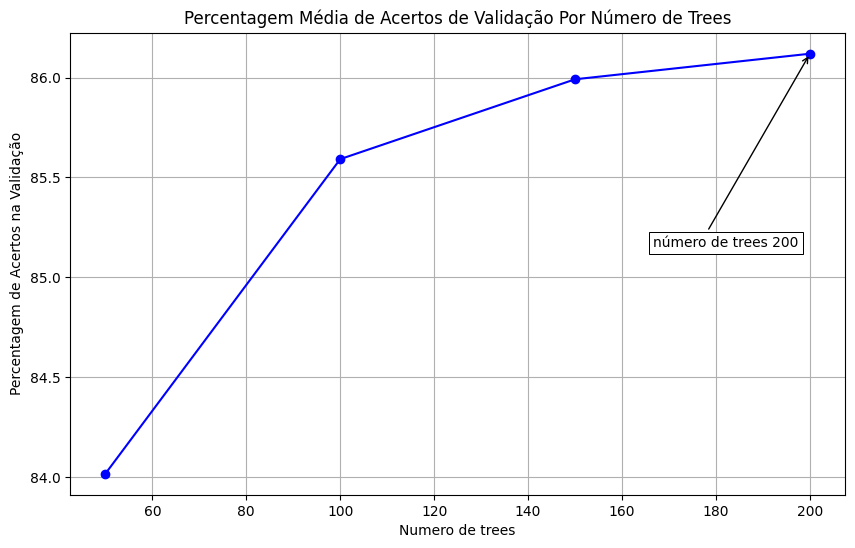

In [11]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(50, 201, 50), resultados_trees_b,  '-o', color='blue')
annot_max(np.arange(50, 201, 50),resultados_trees_b)
plt.title('Percentagem Média de Acertos de Validação Por Número de Trees')
plt.xlabel('Numero de trees')
plt.ylabel('Percentagem de Acertos na Validação')
plt.grid()    

### Melhores Valores

In [12]:
# Vetorização
tfidf_b = pickle.load(open(final_tfidf_bin, 'rb'))['tfidf']
X1t_b, X1v_b, X2_b = tfidf_b.transform(Docs1t_b), tfidf_b.transform(Docs1v_b), tfidf_b.transform(Docs2_b)

# Regressão Logistica
trees_b = RandomForestClassifier(n_estimators=200, random_state=42).fit(X1t_b, y1t_b)

trees_model_bin = 'Modelos/trees_model_bin.p'
pickle.dump({'trees' : trees_b}, open(trees_model_bin, 'wb'))

# Resultados
print('Tamanho Vocabulário:', len(tfidf_b.get_feature_names()))
print('Score Treino:', trees_b.score(X1t_b, y1t_b)*100)
print('Score Validação:', trees_b.score(X1v_b, y1v_b)*100)
print('Score Teste:', trees_b.score(X2_b, y2_b)*100)

C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Tamanho Vocabulário: 143323
Score Treino: 100.0
Score Validação: 86.11999999999999
Score Teste: 86.08


Número de Erros Teste:  1740
Matriz de Confusão Teste:


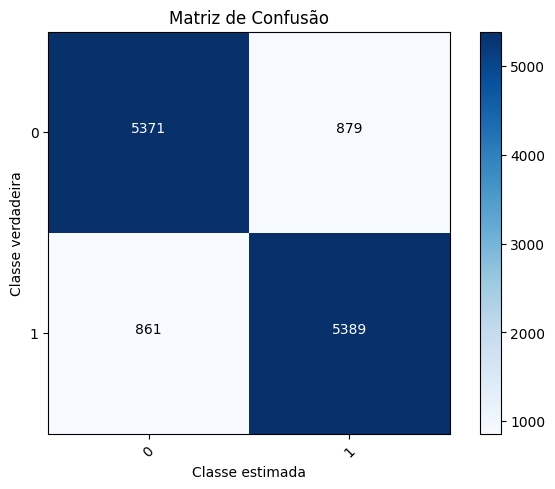

In [13]:
#Matriz Confusão Dados de Teste
print('Número de Erros Teste: ', np.sum(y2_b != trees_b.predict(X2_b)))
MC = confusion_matrix(y2_b, trees_b.predict(X2_b))
print('Matriz de Confusão Teste:')
plotMatriz(MC)

Número de Erros Validação:  1735
Matriz de Confusão Validação:


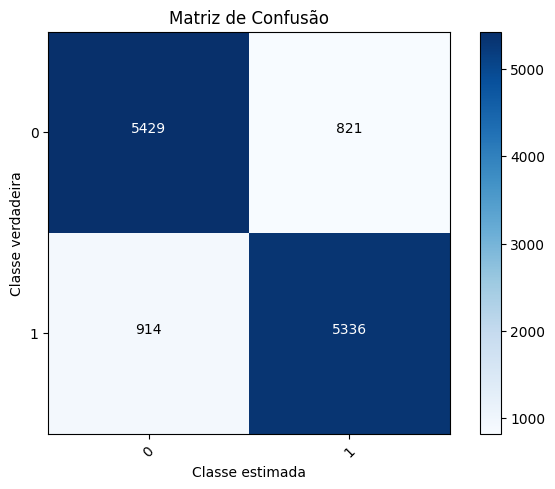

In [14]:
#Matriz de Confusão Dados de Validação
print('Número de Erros Validação: ', np.sum(y1v_b != trees_b.predict(X1v_b)))
MCV = confusion_matrix(y1v_b, trees_b.predict(X1v_b))
print('Matriz de Confusão Validação:')
plotMatriz(MCV)

### Resultados

Número de Erros:  3475


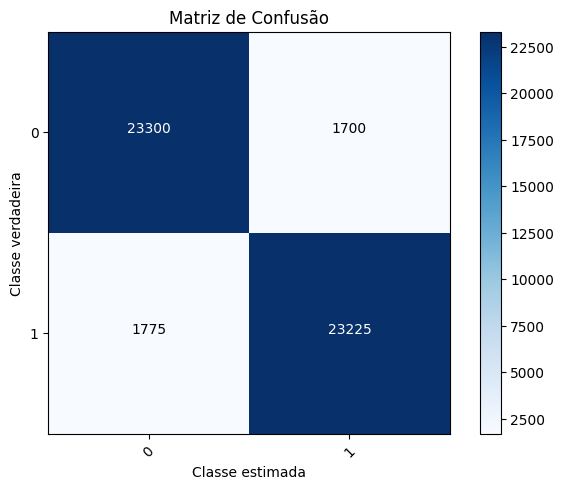

In [15]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs_test_bin_tree, target_test_bin_tree = D['Docs'], D['y']

X_test_bin_tree  = text2vector(Docs_test_bin_tree, 'b', final_tfidf_bin)
ye_test_bin_tree = binClassify(X_test_bin_tree,'trees', False, trees_model_bin)


y_test_bin_tree = target_test_bin_tree.copy()
y_test_bin_tree[y_test_bin_tree < 5] = 0
y_test_bin_tree[y_test_bin_tree > 6] = 1

MC  = confusion_matrix(y_test_bin_tree, ye_test_bin_tree)

print('Número de Erros: ', np.sum(y_test_bin_tree != ye_test_bin_tree))
plotMatriz(MC)

## Caso Multi

In [16]:
final_tfidf_multi = 'tfidf/tfidf_multiclasse.p'

In [17]:
yM = y.copy()

### Divisao em treino e teste

In [18]:
Docs1_m, Docs2_m, y1_m, y2_m     = tts(Docs, yM, test_size=1/4, stratify=yM,random_state=42) #total ---> treino + teste
Docs1t_m, Docs1v_m, y1t_m, y1v_m = tts(Docs1_m, y1_m, test_size=1/3, stratify=y1_m,random_state=42)  #treino ---> treino + validacao 

### Testar n_estimators

In [19]:
tfidf_m = pickle.load(open(final_tfidf_multi, 'rb'))['tfidf']
X1t_m, X1v_m = tfidf_m.transform(Docs1t_m), tfidf_m.transform(Docs1v_m)

trees_m = np.arange(50, 201, 50)

resultados_trees_m = []

for tree in trees_m:
    print(tree)
    rfc_m = RandomForestClassifier(n_estimators=tree, random_state=42).fit(X1t_m, y1t_m)
    resultados_trees_m.append(rfc_m.score(X1v_m, y1v_m)*100)

50
100
150
200


In [20]:
trees_r_b_multi = 'Resultados/trees_r_b_multi.p'

dict_results_multi = {'trees' : resultados_trees_m }

pickle.dump(dict_results_multi, open(trees_r_b_multi, 'wb'))

In [21]:
best_m = pickle.load(open(trees_r_b_multi, 'rb'))

resultados_trees_m = best_m["trees"]

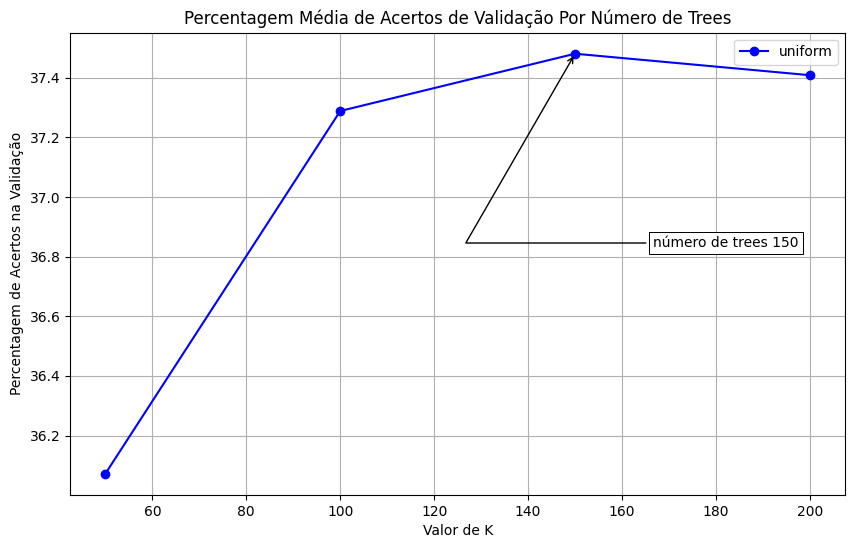

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(50, 201, 50), resultados_trees_m,  '-o', color='blue')
annot_max(np.arange(50, 201, 50),resultados_trees_m)
plt.title('Percentagem Média de Acertos de Validação Por Número de Trees')
plt.xlabel('Valor de K')
plt.ylabel('Percentagem de Acertos na Validação')
plt.legend(('uniform', 'distance'))
plt.grid()    

### Melhores valores

In [24]:
# Vetorização
tfidf_m = pickle.load(open(final_tfidf_multi, 'rb'))['tfidf']
X1t_m, X1v_m, X2_m = tfidf_m.transform(Docs1t_m), tfidf_m.transform(Docs1v_m), tfidf_m.transform(Docs2_m)

# Regressão Logistica
rfc_m = RandomForestClassifier(n_estimators=150, random_state=42).fit(X1t_m, y1t_m)

trees_model_multi = 'Modelos/trees_model_multi.p'
pickle.dump({'trees' : rfc_m}, open(trees_model_multi, 'wb'))



In [25]:
# Resultados
print('Tamanho Vocabulário:', len(tfidf_m.get_feature_names()))
print('Score Treino:', rfc_m.score(X1t_m, y1t_m)*100)
print('Score Validação:', rfc_m.score(X1v_m, y1v_m)*100)
print('Score Teste:', rfc_m.score(X2_m, y2_m)*100)

C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Tamanho Vocabulário: 128551
Score Treino: 99.988
Score Validação: 37.480000000000004
Score Teste: 37.384


Número de Erros Teste:  7827
Matriz de Confusão Teste:


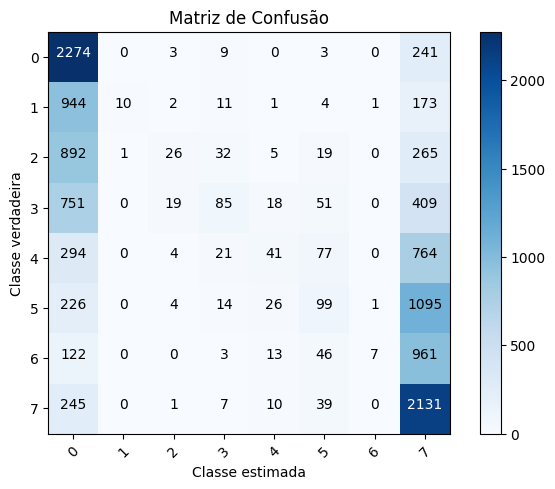

In [26]:
#Matriz Confusão Dados de Teste
print('Número de Erros Teste: ', np.sum(y2_m != rfc_m.predict(X2_m)))
MC = confusion_matrix(y2_m, rfc_m.predict(X2_m))
print('Matriz de Confusão Teste:')
plotMatriz(MC)

Número de Erros Validação:  7815
Matriz de Confusão Validação:


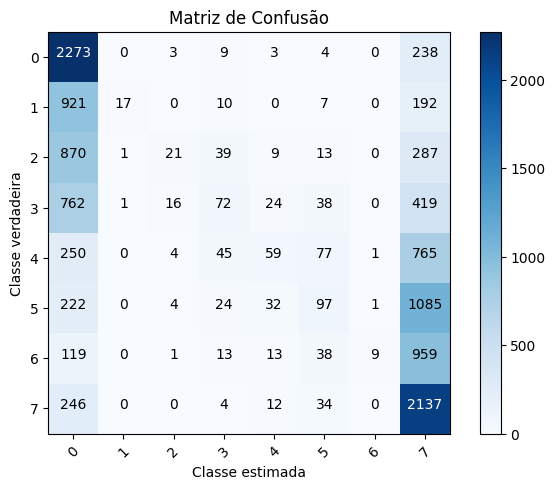

In [27]:
#Matriz de Confusão Dados de Validação
print('Número de Erros Validação: ', np.sum(y1v_m != rfc_m.predict(X1v_m)))
MCV = confusion_matrix(y1v_m, rfc_m.predict(X1v_m))
print('Matriz de Confusão Validação:')
plotMatriz(MCV)

In [28]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs_test_mult_trees, y_test_mult_trees = D['Docs'], D['y']

X_test_mult_trees  = text2vector(Docs_test_mult_trees, 'm', final_tfidf_multi)
ye_test_mult_trees = multiClassify(X_test_mult_trees, 'trees', False, trees_model_multi)


MC  = confusion_matrix(y_test_mult_trees, ye_test_mult_trees)

print('Matriz de Confusão Teste:')
print(MC)
print('\nNúmero de Erros: ', np.sum(y_test_mult_trees != ye_test_mult_trees))

Matriz de Confusão Teste:
[[9609    0    6   18    3    7    0  479]
 [1865 2320    2   21    1   11    1  365]
 [1762    2 2528   71   14   32    0  552]
 [1513    1   36 2822   42   89    0  828]
 [ 544    0    8   66 2500  154    1 1530]
 [ 448    0    8   38   59 3124    2 2180]
 [ 241    0    1   16   26   84 2319 1920]
 [ 491    0    1   11   22   73    0 9133]]

Número de Erros:  15645
